# Some Data Exploration for the White Wine Dataset

## Import the libraries

In [1]:
import sys
from pathlib import Path

import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt

## Load the data

In [2]:
INPUT_DATA_PATH = Path("../data/winequality-white.csv")
dataset_df = pd.read_csv(INPUT_DATA_PATH, sep=";")

## Some Data Trend Exploration

In [3]:
dataset_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
dataset_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
dataset_df['quality'].value_counts()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64

<Axes: xlabel='quality'>

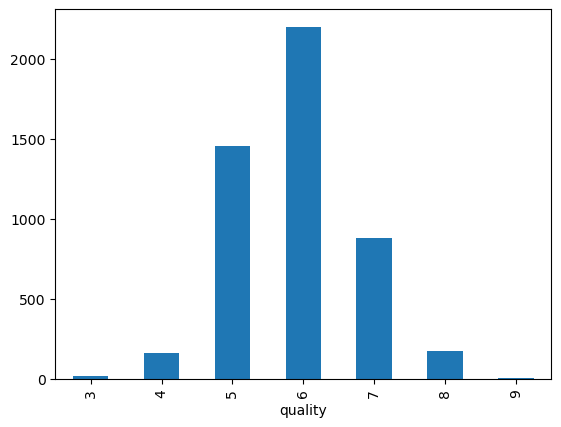

In [6]:
dataset_df.groupby('quality').size().plot(kind="bar")

<Axes: xlabel='quality'>

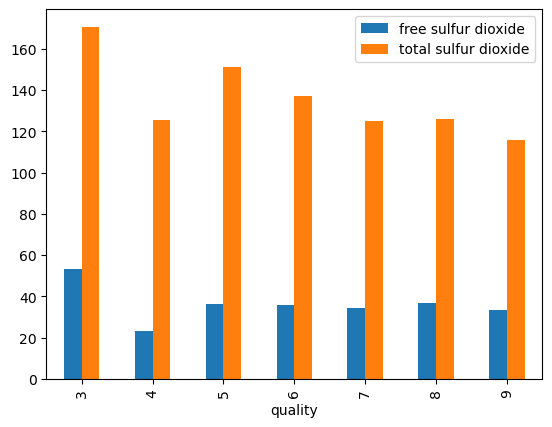

In [7]:
dataset_df.groupby(['quality']).mean().plot(kind="bar", y=["free sulfur dioxide", "total sulfur dioxide"])

In [8]:
dataset_df.groupby(['quality'])[["free sulfur dioxide", "total sulfur dioxide"]].corr()

free sulfur dioxide  total sulfur dioxide
quality                                                                
3       free sulfur dioxide              1.000000              0.776483
        total sulfur dioxide             0.776483              1.000000
4       free sulfur dioxide              1.000000              0.657583
        total sulfur dioxide             0.657583              1.000000
5       free sulfur dioxide              1.000000              0.664293
        total sulfur dioxide             0.664293              1.000000
6       free sulfur dioxide              1.000000              0.596310
        total sulfur dioxide             0.596310              1.000000
7       free sulfur dioxide              1.000000              0.532689
        total sulfur dioxide             0.532689              1.000000
8       free sulfur dioxide              1.000000              0.621078
        total sulfur dioxide             0.621078              1.000000
9       free sulfur dioxide              1.000000              0.168112
        total sulfur dioxide             0.168112              1.000000

<Axes: xlabel='quality'>

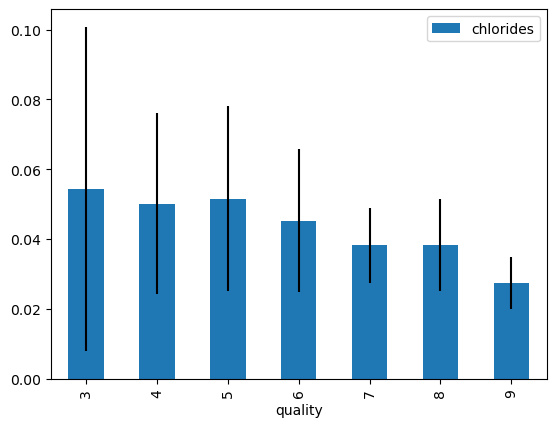

In [9]:
std_devs = dataset_df.groupby(['quality'])[["chlorides"]].std()
dataset_df.groupby(['quality']).mean().plot(kind="bar", y=["chlorides"], yerr=std_devs)

<Axes: xlabel='quality'>

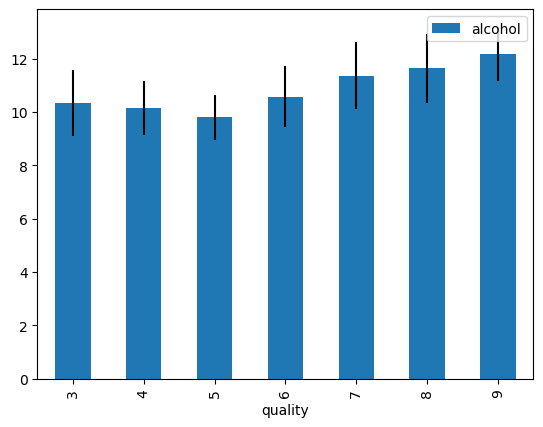

In [10]:
std_devs = dataset_df.groupby(['quality'])[["alcohol"]].std()
dataset_df.groupby(['quality']).mean().plot(kind="bar", y=["alcohol"], yerr=std_devs)

## Load the PyTorch Model to do Prediction Exploration

In [11]:
sys.path.append('..')
import pytorch.train as pyttrain

In [12]:
device = pyttrain.get_device()
model = pyttrain.NeuralNetwork().to(device)

In [13]:
model.load_state_dict(torch.load("../pytorch" / pyttrain.OUTPUT_MODEL_PATH))

with open("../pytorch" / pyttrain.TRAIN_DATASET_PATH, "rb") as f:
    train_dataset = pickle.load(f)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=pyttrain.BATCH_SIZE)

with open("../pytorch" / pyttrain.VALIDATE_DATASET_PATH, "rb") as f:
    validate_dataset = pickle.load(f)
validate_dataloader = torch.utils.data.DataLoader(validate_dataset, batch_size=pyttrain.BATCH_SIZE)

with open("../pytorch" / pyttrain.TEST_DATASET_PATH, "rb") as f:
    test_dataset = pickle.load(f)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=pyttrain.BATCH_SIZE)

## Predict from the Train/Test Datasets

In [15]:
train_pred_scores = []
for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    train_pred_scores += pred.round().tolist()

validate_pred_scores = []
for X, y in validate_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    validate_pred_scores += pred.round().tolist()

test_pred_scores = []
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    test_pred_scores += pred.round().tolist()

## Explore Trends in the Predictions

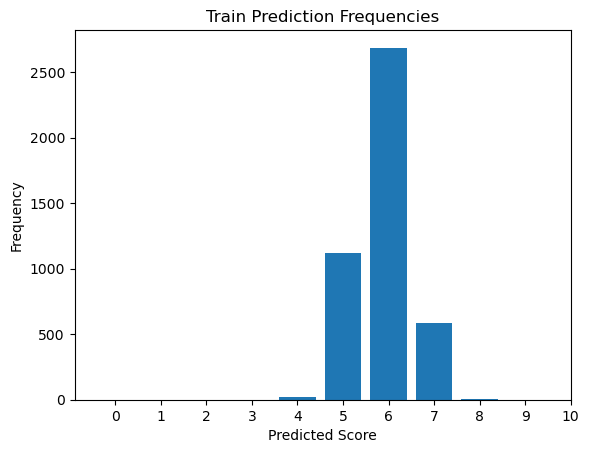

In [16]:
# Create histogram
plt.hist(train_pred_scores, bins=range(11), align='left', rwidth=0.8)

# Set labels and title
plt.title('Train Prediction Frequencies')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.xticks(range(11))

# Show plot
plt.show()

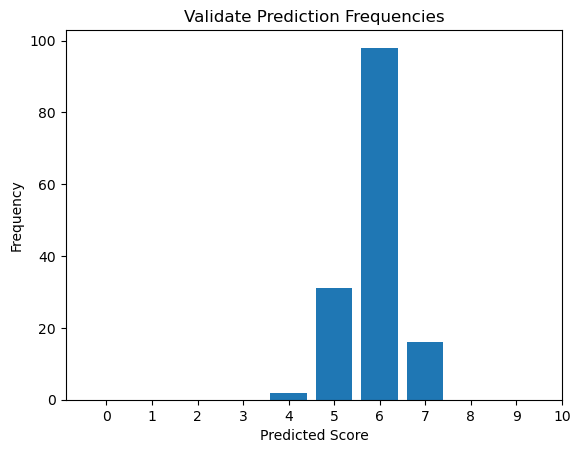

In [17]:
# Create histogram
plt.hist(validate_pred_scores, bins=range(11), align='left', rwidth=0.8)

# Set labels and title
plt.title('Validate Prediction Frequencies')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.xticks(range(11))

# Show plot
plt.show()

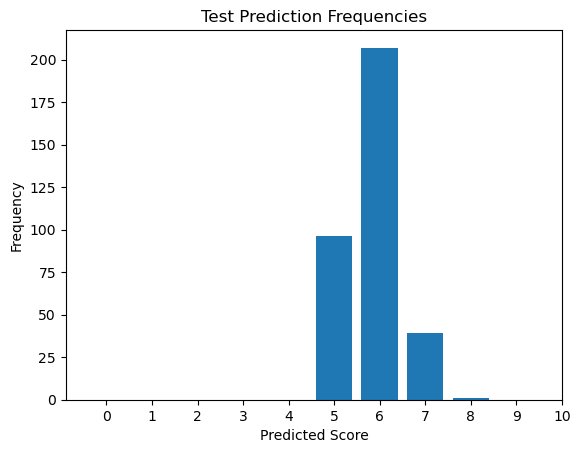

In [18]:
# Create histogram
plt.hist(test_pred_scores, bins=range(11), align='left', rwidth=0.8)

# Set labels and title
plt.title('Test Prediction Frequencies')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.xticks(range(11))

# Show plot
plt.show()